In [16]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.python.ops import math_ops as tfmath_ops
import sys
import time
import pickle
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
%matplotlib inline


## Utility function for data generation
Source code copied from [this repo](https://github.com/scrambledpie/GPVAE) and changed to generate and work with 3d data  


In [29]:
def Make_path_batch(batch=40, tmax=30, lt=5, seed=None):
    """
    Samples x(t), y(t) from a GP
    args:
        batch: number of samples
        tmax: length of samples
        lt: GP length scale
    returns:
        traj: nparray (batch, tmax, 2)
    """
    ilt = -0.5/(lt*lt)
    T = np.arange(tmax)
    Sigma = np.exp( ilt * (T.reshape(-1,1) - T.reshape(1,-1))**2)
    Mu = np.zeros(tmax)
    np.random.seed(seed)
    traj = np.random.multivariate_normal(Mu, Sigma, (batch, 3))
    traj = np.transpose(traj, (0,2,1))
    return traj

def Make_Video_batch(tmax=50, px=10, py=10, pz=10,  lt=5,  batch=40, seed=1, r=2):
    """
    params:
        tmax: number of frames to generate
        px: horizontal resolution
        py: vertical resolution
        lt: length scale
        batch: number of videos
        seed: rng seed
        r: radius of ball in pixels
    returns:
        traj0: (batch, tmax, 2) numpy array
        vid_batch: (batch, tmax, px, py) numpy array
    """
    traj0 = Make_path_batch(batch=batch, tmax=tmax, lt=lt, seed=seed)
    traj = traj0.copy()
    traj[:,:,0] = traj[:,:,0] * (px/5) + (0.5*px)
    traj[:,:,1] = traj[:,:,1] * (py/5) + (0.5*py)
    traj[:,:,2] = traj[:,:,2] * (pz/5) + (0.5*pz)
    rr = r*r*r
    def pixelate_frame(xyz):
        """
        takes a single x,y pixel point and converts to binary image
        with ball centered at x,y.
        """
        x = xyz[0]
        y = xyz[1]
        z = xyz[2]
        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2
        sq_z = (np.arange(pz) - z)**2
        lx = tf.reshape(sq_x, (px, 1, 1))
        ly = tf.reshape(sq_x, (1, py, 1))
        lz = tf.reshape(sq_z, (1,1, pz))
        image = lx + ly +lz< rr
        return image
    
    def pixelate_series(XYZ):
        vid = map(pixelate_frame, XYZ)
        vid = [v for v in vid]
        return np.asarray(vid)
    vid_batch = [pixelate_series(traj_i) for traj_i in traj]
    vid_batch = np.asarray(vid_batch)
    return traj0, vid_batch

In [18]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    """
    Computes the element-wise cross entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu2, var2) ]
    args:
        mu1:  mean of expectation (batch, tmax, 2) tf variable
        var1: var  of expectation (batch, tmax, 2) tf variable
        mu2:  mean of integrand (batch, tmax, 2) tf variable
        var2: var of integrand (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """
    term0 = 1.8378770664093453 # log(2*pi)
    term1 = tf.log(var2)
    term2 = (var1 + mu1**2 - 2*mu1*mu2 + mu2**2) / var2
    cross_entropy = -0.5*( term0 + term1 + term2 )
    return cross_entropy

def gauss_entropy(var1):
    """
    Computes the element-wise entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu1, var1) ] = -0.5 ( log(var1) + 1 + log(2*pi) )
    args:
        var1: var  of expectation (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """
    term0 = tf.log(var1) + 2.8378770664093453 # 1 + log(2*pi)
    cross_entropy = -0.5*( term0 )
    return cross_entropy

def MSE_rotation(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """
    batch, tmax, _ = X.shape
    X = X.reshape((batch*tmax, 3))
    X = np.hstack([X, np.ones((batch*tmax, 1))])
    Y = Y.reshape(batch*tmax, 3)
    W, MSE, _, _ = np.linalg.lstsq(X, Y, rcond=None)
    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan
    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 3)
    VX_rot = np.zeros((batch, tmax, 3, 3))
    if VX is not None:
        W_rot = W[:3,:]
        W_rot_t = np.transpose(W[:3,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot


def build_MLP_inference_graph(vid_batch, layers=[500], tftype=tf.float32):
    """
    Takes a placeholder for batches of videos to be fed in, returns 
    a mean and var of 2d latent space that are tf variables.

    args:
        vid_batch: tf placeholder (batch, tmax, width, height)
        layers: list of widths of fully connected layers
        tftype: data type to use in graph

    returns:
        means:  tf variable, (batch, tmax, 2) x,y points
        vars:  tf variable, (batch, tmax, 2) x,y uncertainties
    """
    batch, tmax, px, py, pz = vid_batch.get_shape()
    # first layer, flatten images to vectors
    h0 = tf.reshape(vid_batch, (batch*tmax, px*py))
    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
        B = tf.Variable(tf.zeros([1, l]), name="encB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)
    # final layer just outputs x,y mean and log(var) of q network
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, 6],
            stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
    B = tf.Variable(tf.zeros([1, 6]), name="encB")
    h0 = tf.matmul(h0, W) + B
    h0 = tf.reshape(h0, (batch, tmax, 6))
    #First 2 mean Next 2 variance
    q_means = h0[:, :, :3]
    q_vars  = tf.exp(h0[:, :, 3:])

    return q_means, q_vars

def build_MLP_decoder_graph(latent_samples, px, py, layers=[500]):
    """
    Constructs a TF graph that goes from latent points in 2D time series
    to a bernoulli probabilty for each pixel in output video time series.
    Args:
        latent_samples: (batch, tmax, 2), tf variable
        px: image width (int)
        py: image height (int)
        layers: list of num. of nodes (list of ints)

    Returns:
        pred_batch_vid_logits: (batch, tmax, px, py) tf variable
    """
    batch, tmax, _ = latent_samples.get_shape()
    # flatten all latents into one matrix (decoded in i.i.d fashion)
    h0 = tf.reshape(latent_samples, (batch*tmax, 3))

    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
        B = tf.Variable(tf.zeros([1, l]), name="decB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs full video batch
    l = px*py
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, l],
            stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
    B = tf.Variable(tf.zeros([1, l]), name="decB")
    h0 = tf.matmul(h0, W) + B
    pred_vid_batch_logits = tf.reshape(h0, (batch, tmax, px, py))
    return pred_vid_batch_logits

def build_1d_gp(X, Y, varY, X_test, lt=5):
    """
    Takes input-output dataset and returns post mean, var, marginal lhood.
    This is standard GP regression (in this application X is time, Y is 
    recognition network means with noise as recognition netowrk variance).

    Args:
        X: inputs tensor (batch, npoints)
        Y: outputs tensor (batch, npoints)
        varY: noise of outputs tensor (batch, npoints)
        X_test: (batch, ns) input points to compute post mean + var

    Returns:
        p_m: (batch, ns) post mean at X_test
        p_v: (batch, ns) post var at X_test
        logZ: (batch) marginal lhood of each dataset in batch
    """
    # Prepare all constants
    batch, _ = X.get_shape()
    n = tf.shape(X)[1]
    _, ns = X_test.get_shape()
    # inverse square length scale
    ilt = tf.constant( -0.5*(1/(lt*lt)) )
    # lhood term 1/3
    lhood_pi_term = tf.cast(n, dtype=tf.float32) * np.log(2*np.pi)
    # data cov matrix K = exp( -1/2 * (X-X)**2/l**2) + noise
    K = tf.reshape(X, (batch, n, 1)) - tf.reshape(X, (batch, 1, n)) # (batch, n n)
    K = tf.exp( (K**2) * ilt)  + tf.matrix_diag(varY) 
    chol_K = tf.linalg.cholesky(K) # (batch, n, n)
    # lhood term 2/3
    lhood_logdet_term = 2*tf.reduce_sum(tf.log(tf.matrix_diag_part(chol_K)), 1) # (batch)
    # lhood term 3/3
    Y = tf.reshape(Y, (batch, n, 1))
    iKY = tf.cholesky_solve( chol_K, Y) # (batch, n, 1)
    lh_quad_term = tf.matmul(tf.reshape(Y, (batch, 1, n)), iKY) # (batch, 1, 1)
    lh_quad_term = tf.reshape(lh_quad_term, [batch])
    # log P(Y|X) = -1/2 * ( n log(2 pi) + Y inv(K+noise) Y + log det(K+noise))
    gp_lhood = -0.5*( lhood_pi_term + lh_quad_term + lhood_logdet_term )
    # Compute posterior mean and variances
    Ks = tf.reshape(X, (batch, n, 1)) - tf.reshape(X_test, (batch, 1, ns)) #broadcasts to (batch, n, ns)
    Ks = tf.exp( (Ks**2) * ilt) # (batch, n, ns)
    Ks_t = tf.transpose(Ks, (0, 2, 1)) # (batch, ns, n)
    # posterior mean
    p_m = tf.matmul(Ks_t, iKY)
    p_m = tf.reshape(p_m, (batch, ns))
    # posterior variance
    iK_Ks = tf.cholesky_solve(chol_K, Ks) # (batch, n, ns)
    Ks_iK_Ks = tf.reduce_sum(Ks * iK_Ks, axis=1) # (batch, ns)
    p_v = 1 - Ks_iK_Ks # (batch, ns)
    p_v = tf.reshape(p_v, (batch, ns))
    return p_m, p_v, gp_lhood



In [19]:
def build_video_batch_graph(tmax=50, px=10, py=10, pz=10, lt=5, batch=1, seed=1, r=2, dtype=tf.float32):
    rr = r*r*r
    ilt = tf.constant(-0.5/(lt**2), dtype=dtype)
    K = tf.range(tmax, dtype=dtype)
    K = (tf.reshape(K, (tmax, 1)) - tf.reshape(K, (1, tmax)))**2
    K = tf.exp(K*ilt) + 0.00001*tf.eye(tmax, dtype=dtype)
    chol_K = tf.Variable(tf.linalg.cholesky(K), trainable=False)
    ran_Z = tf.random.normal((tmax, 3*batch))
    paths = tf.matmul(chol_K, ran_Z)
    paths = tf.reshape(paths, (tmax, batch, 3))
    paths = tf.transpose(paths, (1,0,2))
    # assumes px = py
    paths = paths*0.2*px + 0.5*px
    vid_batch = []
    tf_px = tf.range(px, dtype=dtype)
    tf_py = tf.range(py, dtype=dtype)
    tf_pz = tf.range(pz, dtype=dtype)
    for b in range(batch):
        frames_tmax = []
        for t in range(tmax):
            lx = tf.reshape((tf_px - paths[b,t,0])**2, (px, 1, 1))
            ly = tf.reshape((tf_py - paths[b,t,1])**2, (1, py, 1))
            lz = tf.reshape((tf_py - paths[b,t,2])**2, (1,1, pz))
            frame = lx + ly +lz< rr
            frames_tmax.append(tf.reshape(frame, (1,1,px,py, pz)))
        vid_batch.append(tf.concat(frames_tmax, 1))
    vid_batch = [tfmath_ops.cast(vid, dtype=dtype) for vid in vid_batch]
    vid_batch = tf.concat(vid_batch, 0)
    return vid_batch

def build_MLP_inference_graph(vid_batch, layers=[500], tftype=tf.float32):
    """
    Takes a placeholder for batches of videos to be fed in, returns 
    a mean and var of 2d latent space that are tf variables.

    args:
        vid_batch: tf placeholder (batch, tmax, width, height)
        layers: list of widths of fully connected layers
        tftype: data type to use in graph

    returns:
        means:  tf variable, (batch, tmax, 2) x,y points
        vars:  tf variable, (batch, tmax, 2) x,y uncertainties
    """
    batch, tmax, px, py ,pz = vid_batch.get_shape()
    # first layer, flatten images to vectors
    h0 = tf.reshape(vid_batch, (batch*tmax, px*py*pz))
    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
        B = tf.Variable(tf.zeros([1, l]), name="encB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)
    # final layer just outputs x,y mean and log(var) of q network
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, 6],
            stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
    B = tf.Variable(tf.zeros([1, 6]), name="encB")
    h0 = tf.matmul(h0, W) + B
    h0 = tf.reshape(h0, (batch, tmax, 6))
    q_means = h0[:, :, :3]
    q_vars  = tf.exp(h0[:, :, 3:])
    return q_means, q_vars
def build_MLP_decoder_graph(latent_samples, px, py,pz, layers=[500]):
    """
    Constructs a TF graph that goes from latent points in 2D time series
    to a bernoulli probabilty for each pixel in output video time series.
    Args:
        latent_samples: (batch, tmax, 2), tf variable
        px: image width (int)
        py: image height (int)
        layers: list of num. of nodes (list of ints)

    Returns:
        pred_batch_vid_logits: (batch, tmax, px, py) tf variable
    """
    batch, tmax, _ = latent_samples.get_shape()
    h0 = tf.reshape(latent_samples, (batch*tmax, 3))
    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
        B = tf.Variable(tf.zeros([1, l]), name="decB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs full video batch
    l = px*py*pz
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, l],
            stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
    B = tf.Variable(tf.zeros([1, l]), name="decB")
    h0 = tf.matmul(h0, W) + B
    pred_vid_batch_logits = tf.reshape(h0, (batch, tmax, px, py, pz))
    return pred_vid_batch_logits


In [20]:
def build_sin_and_np_elbo_graphs(vid_batch, beta, lt=5, context_ratio=0.5):
    """
    Builds both standard (sin) eblo and neural process (np) elbo. 
    Returns pretty much everything!
    Args:
        vid_batch: tf variable (batch, tmax, px, py) binay arrays or images
        beta: scalar, tf variable, annealing term for prior KL
        lt: length scale of GP
        context_ratio: float in [0,1], for np elbo, random target-context split ratio

    Returns:
        sin_elbo: "standard" elbo
        sin_elbo_recon: recon struction term
        sin_elbo_prior_kl: prior KL term
        np_elbo: neural process elbo
        np_elbo_recon: ...
        np_prior_kl: ...
        full_p_mu: approx posterior mean
        full_p_var: approx post var
        qnet_mu: recognition network mean
        qnet_var: recog. net var
        pred_vid: reconstructed video
        globals(): aaaalll variables in local scope
    """
    batch, tmax, px, py, pz= [int(s) for s in vid_batch.get_shape()]

    # Choose a random split of target-context for each batch
    con_tf = tf.random.normal(shape=(),
                              mean=context_ratio*float(tmax),
                              stddev=np.sqrt(context_ratio*(1-context_ratio)*float(tmax)))
    con_tf = tf.math.maximum(con_tf, 2)
    con_tf = tf.math.minimum(con_tf, int(tmax)-2)
    con_tf = tf.cast(tf.round(con_tf), tf.int32)

    dt = vid_batch.dtype
    
    # recognition network terms
    qnet_mu, qnet_var = build_MLP_inference_graph(vid_batch)

    ##################################################################
    ####################### CONTEXT LIKELIHOOD #######################
    # make random indices
    ran_ind = tf.range(tmax, dtype=tf.int32)
    ran_ind = [tf.random.shuffle(ran_ind) for i in range(batch)] # (batch, tmax)
    ran_ind = [tf.reshape(r_i, (1,tmax)) for r_i in ran_ind] # len batch list( (tmax), ..., (tmax) )
    ran_ind = tf.concat(ran_ind, 0) # ()

    con_ind = ran_ind[:, :con_tf]
    tar_ind = ran_ind[:, con_tf:]

    T = tf.range(tmax, dtype=dt)
    batch_T = tf.concat([tf.reshape(T, (1,tmax)) for i in range(batch)], 0) # (batch, tmax)

    # time stamps of context points
    con_T = [tf.gather(T, con_ind[i,:]) for i in range(batch)]
    con_T = [tf.reshape(ct, (1,con_tf)) for ct in con_T]
    con_T = tf.concat(con_T, 0)

    # encoded means of contet points
    con_lm = [tf.gather(qnet_mu[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lm = [tf.reshape(cm, (1,con_tf,3)) for cm in con_lm]
    con_lm = tf.concat(con_lm, 0)

    # encoded variances of context points
    con_lv = [tf.gather(qnet_var[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lv = [tf.reshape(cv, (1,con_tf,3)) for cv in con_lv]
    con_lv = tf.concat(con_lv, 0)

    # conext Lhoods
    _,_, con_lhoodx = build_1d_gp(con_T, con_lm[:,:,0], con_lv[:,:,0], batch_T)
    _,_, con_lhoody = build_1d_gp(con_T, con_lm[:,:,1], con_lv[:,:,1], batch_T)
    _,_, con_lhoodz = build_1d_gp(con_T, con_lm[:,:,2], con_lv[:,:,2], batch_T)
    con_lhood = con_lhoodx + con_lhoody + con_lhoodz


    ####################################################################################
    #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################

    # posterior and lhood for full dataset
    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T)
    p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,:,1], qnet_var[:,:,1], batch_T)
    p_mz, p_vz, full_lhoodz = build_1d_gp(batch_T, qnet_mu[:,:,2], qnet_var[:,:,2], batch_T)

    full_p_mu = tf.stack([p_mx, p_my, p_mz], axis=2)
    full_p_var = tf.stack([p_vx, p_vy, p_vz], axis=2)

    full_lhood = full_lhoodx + full_lhoody + full_lhoodz

    ####################################################################################
    ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

    # cross entropy term
    sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 2) # (batch, tmax)


    np_elbo_ce = [tf.gather(sin_elbo_ce[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_ce = [tf.reduce_sum(np_i) for np_i in np_elbo_ce] # list of scalars, len=batch

    np_elbo_ce = tf.stack(np_elbo_ce) # (batch)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 1) # (batch)


    ####################################################################################
    ################################ Prior KL 3/3 ######################################

    sin_elbo_prior_kl = full_lhood - sin_elbo_ce
    np_prior_kl       = full_lhood - np_elbo_ce - con_lhood


    ####################################################################################
    ########################### RECONSTRUCTION TERMS ###################################

    epsilon = tf.random.normal(shape=(batch, tmax, 3))
    latent_samples = full_p_mu + epsilon * tf.sqrt(full_p_var)
    pred_vid_batch_logits = build_MLP_decoder_graph(latent_samples, px, py, pz)
    pred_vid = tf.nn.sigmoid(pred_vid_batch_logits)
    recon_err = tf.nn.sigmoid_cross_entropy_with_logits(labels=vid_batch, 
                                                        logits=pred_vid_batch_logits)
    sin_elbo_recon = tf.reduce_sum(-recon_err, (2,3, 4)) # (batch, tmax)
    np_elbo_recon = [tf.gather(sin_elbo_recon[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_recon = [tf.reduce_sum(np_i) for np_i in np_elbo_recon]

    # finally the reconstruction error for each objective!
    np_elbo_recon = tf.stack(np_elbo_recon)  # (batch)
    sin_elbo_recon = tf.reduce_sum(sin_elbo_recon, 1) # (batch)



    #####################################################################################
    ####################### PUT IT ALL TOGETHER  ########################################

    sin_elbo = sin_elbo_recon + beta * sin_elbo_prior_kl
    
    np_elbo  = np_elbo_recon + beta * np_prior_kl

    return sin_elbo, sin_elbo_recon, sin_elbo_prior_kl, \
           np_elbo,   np_elbo_recon,       np_prior_kl, \
           full_p_mu, full_p_var, \
           qnet_mu, qnet_var, pred_vid, globals()

## TRAINING

### Globals

In [21]:
default_base_dir = os.getcwd()

parser = argparse.ArgumentParser(description='Train GPP-VAE')
parser.add_argument('--steps', type=int, default=50000, help='Number of steps of Adam')
parser.add_argument('--beta0', type=float, default=1, help='initial beta annealing value')
parser.add_argument('--elbo', type=str, choices=['SIN', 'NP'], default='SIN',
                     help='Structured Inf Nets ELBO or Neural Processes ELBO')
parser.add_argument('--modellt', type=float, default=5, help='time scale of model to fit to data')
parser.add_argument('--base_dir', type=str, default=default_base_dir, help='folder within a new dir is made for each run')
parser.add_argument('--expid', type=str, default="debug", help='give this experiment a name')
parser.add_argument('--ram', type=float, default=0.5, help='fraction of GPU ram to use')
parser.add_argument('--seed', type=int, default=None, help='seed for rng')
args = parser.parse_args([])

In [22]:
batch = 35
tmax = 30
px = py = pz =16
r = 2
vid_lt = 5
model_lt = args.modellt

## Plotting Utilities

In [27]:
def getSeris(M):
    x = []
    y = []
    z = []
    colmap =[]
    for i in range(16):
        for j in range(16):
            for k in range(16):
                x.append(i)
                y.append(j)
                z.append(k)
                colmap.append(M[i][j][k])
    return x,y,z,colmap 


def plot_latents(truepath, reconpath=None, fig=None, nplots=4):
    """
    Plots an array of input videos and reconstructions.
    args:
        truevids: (batch, tmax, px, py) np array of videos
        truepath: (batch, tmax, 2) np array of latent positions
        reconvids: (batch, tmax, px, py) np array of videos
        reconpath: (batch, tmax, 2) np array of latent positions
        reconvar: (batch, tmax, 2, 2) np array, cov mat 
        ax: (optional) list of lists of axes objects for plotting
        nplots: int, number of rows of plot, each row is one video
        paths: (batch, tmax, 2) np array optional extra array to plot

    returns:
        fig: figure object with all plots

    """
    tmax = truepath.shape[1]
    # get axis limits for the latent space
    xmin = np.min([truepath[:nplots,:,0].min(), 
                   reconpath[:nplots,:,0].min()]) -0.1
    xmin = np.min([xmin, -2.5])
    xmax = np.max([truepath[:nplots,:,0].max(), 
                   reconpath[:nplots,:,0].max()]) +0.1
    xmax = np.max([xmax, 2.5])

    ymin = np.min([truepath[:nplots,:,1].min(), 
                   reconpath[:nplots,:,1].min()]) -0.1
    ymin = np.min([ymin, -2.5])
    ymax = np.max([truepath[:nplots,:,1].max(), 
                   reconpath[:nplots,:,1].max()]) +0.1
    ymax = np.max([xmax, 2.5])
    
    zmin = np.min([truepath[:nplots,:,2].min(), 
                   reconpath[:nplots,:,2].min()]) -0.1
    zmin = np.min([zmin, -2.5])
    zmax = np.max([truepath[:nplots,:,2].max(), 
                   reconpath[:nplots,:,2].max()]) +0.1
    zmax = np.max([xmax, 2.5])
    def plot_set(i):
        n = 200+nplots*10+i+1+nplots
        ax = fig.add_subplot(n, projection='3d')
        ax.plot(truepath[i,:,0], truepath[i,:,1], truepath[i,:,2])
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_ylim([zmin, zmax])
        ax.scatter(truepath[i,-1,0], truepath[i,-1,1], truepath[i,-1,2])
        
        if reconpath is not None:
            ax.plot(reconpath[i,:,0], reconpath[i,:,1],  reconpath[i,:,2])
            ax.scatter(reconpath[i,-1,0], reconpath[i,-1,1], reconpath[i,-1,2])
    for i in range(nplots):
        plot_set(i)

def plot_reconstruction(TD, reconvid, TT, rp, iteration, px = 16, nplots = 3):
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(f"ITERATION {iteration}")
    b = 200+nplots*10
    for i in range(nplots):
        n = b+i+1
        ax = fig.add_subplot(n, projection='3d')
        ax.set_xlim(0,px)
        ax.set_ylim(0,px)
        ax.set_zlim(0,px)
        for j in range(TD.shape[1]):
            z,x,y = TD[i][j].nonzero()
            ax.scatter(x, y, z, zdir='z',cmap='Greys')
        plot_latents(TT, reconpath= rp, fig=fig, nplots=nplots)    
    plt.savefig("result_final.png")
    plt.pause(0.5);
    clear_output(wait=True);        


### Training and eval loop

ITERATION 2859


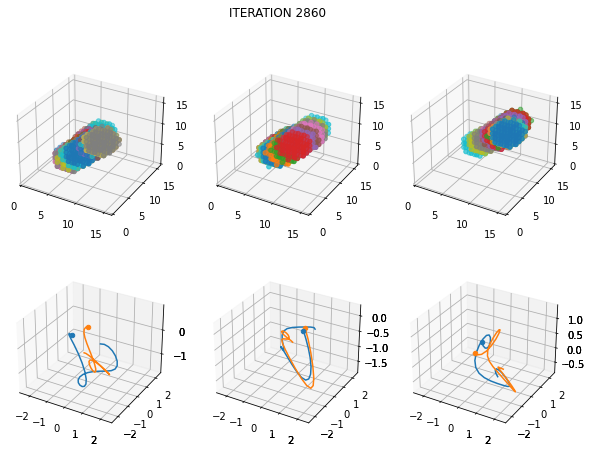

In [ ]:
make_batch = lambda s: Make_Video_batch(tmax=tmax, px=px, py=py, pz=pz, lt=vid_lt, batch=batch, seed=s, r=r)
Test_Batches = [make_batch(s) for s in range(10)]
graph = tf.Graph()
with graph.as_default():
    # Make all the graphs
    beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
    vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=r, lt=vid_lt)
    s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
        p_m,p_v,q_m,q_v,pred_vid, _ = build_sin_and_np_elbo_graphs(vid_batch, beta, lt=model_lt)

    # The actual loss functions
    if args.elbo=="SIN":
        loss  = -tf.reduce_mean(s_elbo)
        e_elb = tf.reduce_mean(s_elbo)
        e_pkl = tf.reduce_mean(s_pkl)
        e_rec = tf.reduce_mean(s_rec)
    elif args.elbo=="NP":
        loss  = -tf.reduce_mean(np_elbo)
        e_elb = tf.reduce_mean(np_elbo)
        e_pkl = tf.reduce_mean(np_pkl)
        e_rec = tf.reduce_mean(np_rec)

    av_s_elbo = tf.reduce_mean(s_elbo)
    av_s_rec  = tf.reduce_mean(s_rec)
    av_s_pkl  = tf.reduce_mean(s_pkl)
    # Add optimizer ops to graph (minimizing neg elbo!), print out trainable vars
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer  = tf.compat.v1.train.AdamOptimizer()
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    optim_step = optimizer.minimize(loss=loss, 
                                    var_list=train_vars,
                                    global_step=global_step)
    print("\n\nTrainable variables:")
    for v in train_vars:
        print(v)
    # Initializer ops for the graph and saver
    init_op = tf.global_variables_initializer()
    saver = tf.compat.v1.train.Saver()
    # Results to be tracked and Pandas saver
    res_vars = [global_step,
                loss,
                av_s_elbo,
                av_s_rec,
                av_s_pkl,
                e_elb,
                e_rec,
                e_pkl,
                tf.math.reduce_min(q_v),
                tf.math.reduce_max(q_v),
                tf.math.reduce_min(p_v),
                tf.math.reduce_max(p_v)]
    res_names= ["Step",
                "Loss",
                "Test ELBO",
                "Test Reconstruction",
                "Test Prior KL",
                "Train ELBO",
                "Train Reconstruction",
                "Train Prior KL",
                "min qs_var",
                "max qs_var",
                "min q_var",
                "max q_var",
                "MSE",
                "Beta",
                "Time"]
        # Now let's start doing some computation!
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=args.ram)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

        # Attempt to restore weights
        try:
            saver.restore(sess, tf.train.latest_checkpoint(chkpnt_dir))
            print("\n\nRestored Model Weights")
        except:
            sess.run(init_op)
            print("\n\nInitialised Model Weights")

        # Start training that elbo!
        for t in range(args.steps):

            # Annealing factor for prior KL
            beta_t = 1 + (args.beta0-1) * np.exp(t/2000)
            # Train: do an optim step
            _, g_s = sess.run([optim_step, global_step], {beta:beta_t})
            if g_s%20==0:
                print("ITERATION", t)
                # [[ax_ij.clear() for ax_ij in ax_i] for ax_i in ax]
                TT, TD = Test_Batches[0]
                reconpath, reconvar, reconvid = sess.run([p_m, p_v, pred_vid], {vid_batch:TD, beta:1})
                rp, W, MSE, rv = MSE_rotation(reconpath, TT, reconvar)
                k = 8
                plot_reconstruction(TD[k:], reconvid[k:], TT[k:], rp[k:], g_s)
